In [1]:
#-------------------------------------------------------------------------------
# import libraries
#-------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ----------------------------
# 1. Define Constants and Initial Conditions
# ----------------------------

# Physical Constants
G_N = 6.67430e-11       # Gravitational constant (m^3 kg^-1 s^-2)
M_sun = 1.98847e30      # Mass of the Sun (kg)

# Unit Definitions
R0 = 1e10               # Distance unit (meters)
T0 = 86400              # Time unit (1 Earth day in seconds)
c = (0.03*R0)/(T0/86400) # Speed of light in units of R0/T0
print(f"Speed of light in units of R0/T0: {c:.3e} R0/T0\n")


# Schwarzschild Radius of the Sun
# r_s = (2 * G_N * M_sun) / (c**2)    # meters
r_s = (1.98*R0**3/(T0**2))/c**2 # meters
print(f"Schwarzschild radius of the Sun: {r_s:.3e} meters\n")

# Initial Conditions for Mercury
x0 = 6.0 * R0                 # Initial x-position (meters)
y0 = 0.0 * R0                 # Initial y-position (meters)
v_x0 = 0.0                    # Initial x-velocity (m/s)
v_y0 = 0.510 * R0 / T0        # Initial y-velocity (m/s)

# Simulation Parameters
total_time_days = 352.0        # Total simulation time in Earth days (4 Mercury years)
total_time = total_time_days * T0   # Convert to seconds

# Time Steps for Each Method (in Earth days)
delta_ts_euler = [5e-4, 5e-1, 1.0]         # Euler Method
delta_ts_leapfrog = [5e-4, 5e-1, 1.0]      # Leap-Frog Method
delta_ts_rk4 = [5e-1, 1.0]                  # 4th Order Runge-Kutta Method
delta_ts_rk4_GR = [0.05]                 # 4th Order Runge-Kutta Method with General Relativity
delta_ts_leapfrog_GR = [0.05]

Speed of light in units of R0/T0: 3.000e+08 R0/T0

Schwarzschild radius of the Sun: 2.947e+03 meters



In [3]:
# ----------------------------
# 2. Define the Acceleration Function
# ----------------------------

def compute_gravitational_acceleration(x, y, c, r_s):
    r = np.sqrt(x**2 + y**2)
    
    if r == 0:
        raise ValueError("Mercury is at the origin (r = 0), which is undefined for acceleration.")
    
    factor = -(c**2 * r_s) / (2 * r**3)
    a_x = factor * x
    a_y = factor * y
    
    return a_x, a_y

In [4]:
# ----------------------------
# 3. Implement Numerical Integration Methods
# ----------------------------

# Euler Method

def euler_method(tau, total_time, x0, y0, v_x0, v_y0, r_s, c):

    steps = int(total_time / tau)
    # Initialize arrays
    t = np.zeros(steps+1)
    x = np.zeros(steps+1)
    y = np.zeros(steps+1)
    v_x = np.zeros(steps+1)
    v_y = np.zeros(steps+1)
    
    # Set initial conditions
    t[0] = 0.0
    x[0] = x0
    y[0] = y0
    v_x[0] = v_x0
    v_y[0] = v_y0
    
    for i in range(steps):
        # Compute acceleration at current position
        a_x, a_y = compute_gravitational_acceleration(x[i], y[i], c, r_s)
        # Update velocities
        v_x[i+1] = v_x[i] + a_x * tau
        v_y[i+1] = v_y[i] + a_y * tau
        
        # Update positions
        x[i+1] = x[i] + v_x[i] * tau
        y[i+1] = y[i] + v_y[i] * tau
        
        # Update time
        t[i+1] = t[i] + tau
        
        # Termination condition: Mercury gets too close
        r = np.sqrt(x[i+1]**2 + y[i+1]**2)
        if r < 0.47 * R0:
            print(f"Euler Method: Terminating simulation at step {i+1}, r = {r:.3e} m")
            # Truncate arrays up to current step
            t = t[:i+2]
            x = x[:i+2]
            y = y[:i+2]
            v_x = v_x[:i+2]
            v_y = v_y[:i+2]
            break
    
    return t, x, y, v_x, v_y

In [5]:
# Leap-Frog Method

def leap_frog_method(tau, total_time, x0, y0, v_x0, v_y0, r_s, c):

    steps = int(total_time / tau)
    # Initialize arrays
    t = np.zeros(steps+1)
    x = np.zeros(steps+1)
    y = np.zeros(steps+1)
    v_x = np.zeros(steps+1)
    v_y = np.zeros(steps+1)
    
    # Set initial conditions
    t[0] = 0.0
    x[0] = x0
    y[0] = y0
    v_x[0] = v_x0
    v_y[0] = v_y0
    
    # Compute initial acceleration
    a_x, a_y = compute_gravitational_acceleration(x[0], y[0], c, r_s)
    # Half-step velocity update
    v_x_half = v_x[0] + 0.5 * a_x * tau
    v_y_half = v_y[0] + 0.5 * a_y * tau
    
    for i in range(steps):
        # Update positions using half-step velocities
        x[i+1] = x[i] + v_x_half * tau
        y[i+1] = y[i] + v_y_half * tau
        
        # Update time
        t[i+1] = t[i] + tau
        
        # Compute acceleration at new position
        a_x_new, a_y_new = compute_gravitational_acceleration(x[i+1], y[i+1], c, r_s)
        # Update half-step velocities
        v_x_half += a_x_new * tau
        v_y_half += a_y_new * tau
        
        # Full-step velocity update, not a must for Leap-Frog but included for consistency
        v_x[i+1] = v_x_half - 0.5 * a_x_new * tau
        v_y[i+1] = v_y_half - 0.5 * a_y_new * tau
        
        # Termination condition
        r = np.sqrt(x[i+1]**2 + y[i+1]**2)
        if r < 0.47 * R0:
            print(f"Leap-Frog Method: Terminating simulation at step {i+1}, r = {r:.3e} m")
            # Truncate arrays up to current step
            t = t[:i+2]
            x = x[:i+2]
            y = y[:i+2]
            v_x = v_x[:i+2]
            v_y = v_y[:i+2]
            break
    
    return t, x, y, v_x, v_y


In [6]:
# 4th Order Runge-Kutta Method

def rk4_method(tau, total_time, x0, y0, v_x0, v_y0, r_s, c):

    steps = int(total_time / tau)
    # Initialize arrays
    t = np.zeros(steps+1)
    x = np.zeros(steps+1)
    y = np.zeros(steps+1)
    v_x = np.zeros(steps+1)
    v_y = np.zeros(steps+1)
    
    # Set initial conditions
    t[0] = 0.0
    x[0] = x0
    y[0] = y0
    v_x[0] = v_x0
    v_y[0] = v_y0
    
    for i in range(steps):
        # Current state
        current_t = t[i] #assigned just in case there is time depeendent factor 
        current_x = x[i]
        current_y = y[i]
        current_vx = v_x[i]
        current_vy = v_y[i]
        
        # Compute k1

        a_x1, a_y1 = compute_gravitational_acceleration(current_x, current_y, c, r_s)

        k1_vx = a_x1
        k1_vy = a_y1
        k1_x = current_vx
        k1_y = current_vy
        
        # Compute k2
        mid_x = current_x + 0.5 * tau * k1_x
        mid_y = current_y + 0.5 * tau * k1_y

        a_x2, a_y2 = compute_gravitational_acceleration(mid_x, mid_y, c, r_s)
   
        k2_vx = a_x2
        k2_vy = a_y2
        k2_x = current_vx + 0.5 * tau * k1_vx
        k2_y = current_vy + 0.5 * tau * k1_vy
        
        # Compute k3
        mid_x = current_x + 0.5 * tau * k2_x
        mid_y = current_y + 0.5 * tau * k2_y

        a_x3, a_y3 = compute_gravitational_acceleration(mid_x, mid_y, c, r_s)
        k3_vx = a_x3
        k3_vy = a_y3
        k3_x = current_vx + 0.5 * tau * k2_vx
        k3_y = current_vy + 0.5 * tau * k2_vy
        
        # Compute k4
        end_x = current_x + tau * k3_x
        end_y = current_y + tau * k3_y
        a_x4, a_y4 = compute_gravitational_acceleration(end_x, end_y, c, r_s)
        k4_vx = a_x4
        k4_vy = a_y4
        k4_x = current_vx + tau * k3_vx
        k4_y = current_vy + tau * k3_vy
        
        # Update positions
        x[i+1] = current_x + (tau / 6.0) * (k1_x + 2*k2_x + 2*k3_x + k4_x)
        y[i+1] = current_y + (tau / 6.0) * (k1_y + 2*k2_y + 2*k3_y + k4_y)
        
        # Update velocities
        v_x[i+1] = current_vx + (tau / 6.0) * (k1_vx + 2*k2_vx + 2*k3_vx + k4_vx)
        v_y[i+1] = current_vy + (tau / 6.0) * (k1_vy + 2*k2_vy + 2*k3_vy + k4_vy)
        
        # Update time
        t[i+1] = t[i] + tau
        
        # Termination condition
        r = np.sqrt(x[i+1]**2 + y[i+1]**2)
        if r < 0.47 * R0:
            print(f"RK4 Method: Terminating simulation at step {i+1}, r = {r:.3e} meters")
            # Truncate arrays up to current step
            t = t[:i+2]
            x = x[:i+2]
            y = y[:i+2]
            v_x = v_x[:i+2]
            v_y = v_y[:i+2]
            break
    
    return t, x, y, v_x, v_y

In [7]:
# ----------------------------
# 4. Run Simulations
# ----------------------------

# Define simulation methods and their respective delta t's
methods = {
    'Euler': delta_ts_euler,
    'Leap-Frog': delta_ts_leapfrog,
    'RK4': delta_ts_rk4
}

# Initialize storage for simulation results
simulation_results = []

# Iterate over each method and its time steps
for method_name, delta_ts in methods.items():
    for tau_days in delta_ts:
        tau_seconds = tau_days * T0    # Convert Earth days to seconds
        print(f"Running {method_name} Method with Δt = {tau_days} Earth days ({tau_seconds:.2f} seconds)")
        
        # Perform simulation based on the method
        if method_name == 'Euler':
            t, x, y, v_x, v_y = euler_method(tau_seconds, total_time, x0, y0, v_x0, v_y0, r_s, c)
        elif method_name == 'Leap-Frog':
            t, x, y, v_x, v_y = leap_frog_method(tau_seconds, total_time, x0, y0, v_x0, v_y0, r_s, c)
        elif method_name == 'RK4':
            t, x, y, v_x, v_y = rk4_method(tau_seconds, total_time, x0, y0, v_x0, v_y0, r_s, c)
        else:
            print(f"Unknown method: {method_name}. Skipping...")
            continue
        
        # Store the results
        simulation_results.append({
            'method': method_name,
            'delta_t_days': tau_days,
            't': t,
            'x': x,
            'y': y,
            'v_x': v_x,
            'v_y': v_y
        })
        print(f"Completed {method_name} Method with Δt = {tau_days} Earth days\n")

Running Euler Method with Δt = 0.0005 Earth days (43.20 seconds)
Completed Euler Method with Δt = 0.0005 Earth days

Running Euler Method with Δt = 0.5 Earth days (43200.00 seconds)
Completed Euler Method with Δt = 0.5 Earth days

Running Euler Method with Δt = 1.0 Earth days (86400.00 seconds)
Completed Euler Method with Δt = 1.0 Earth days

Running Leap-Frog Method with Δt = 0.0005 Earth days (43.20 seconds)
Completed Leap-Frog Method with Δt = 0.0005 Earth days

Running Leap-Frog Method with Δt = 0.5 Earth days (43200.00 seconds)
Completed Leap-Frog Method with Δt = 0.5 Earth days

Running Leap-Frog Method with Δt = 1.0 Earth days (86400.00 seconds)
Completed Leap-Frog Method with Δt = 1.0 Earth days

Running RK4 Method with Δt = 0.5 Earth days (43200.00 seconds)
Completed RK4 Method with Δt = 0.5 Earth days

Running RK4 Method with Δt = 1.0 Earth days (86400.00 seconds)
Completed RK4 Method with Δt = 1.0 Earth days



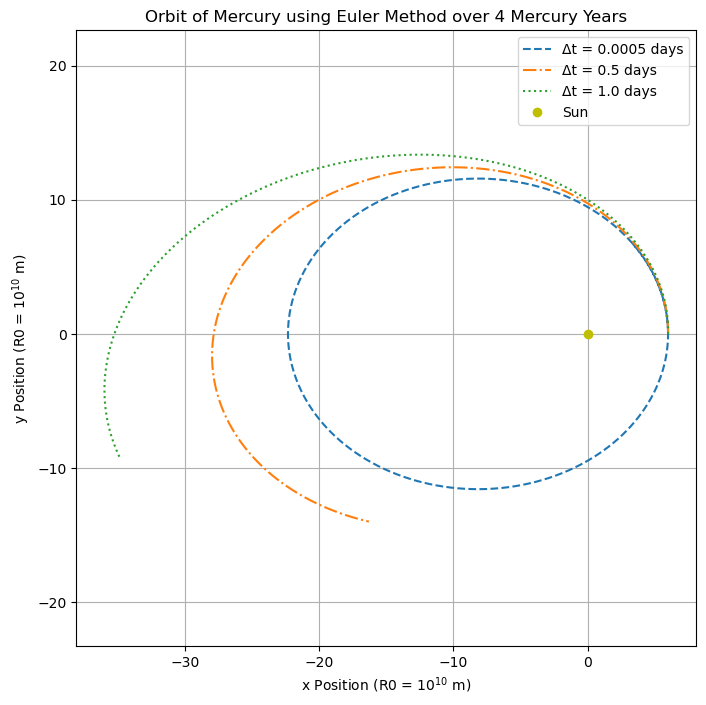

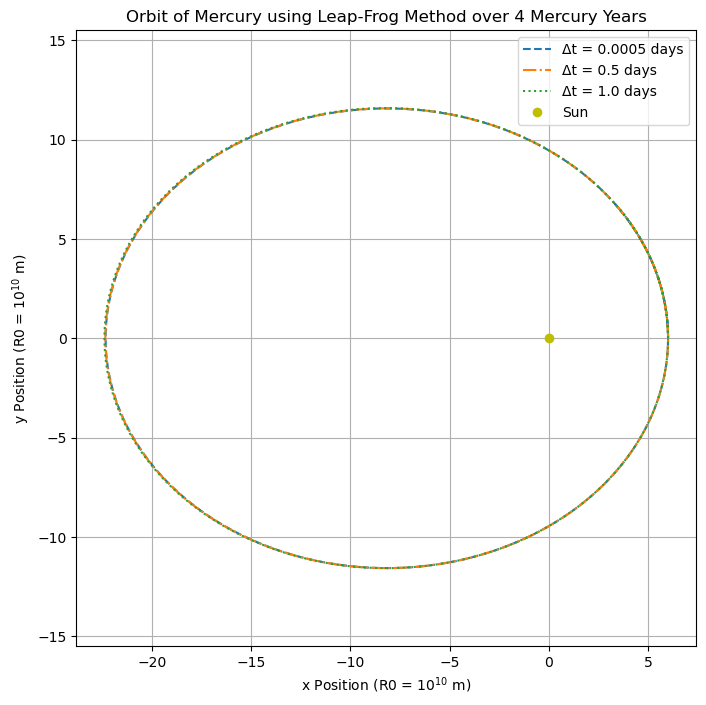

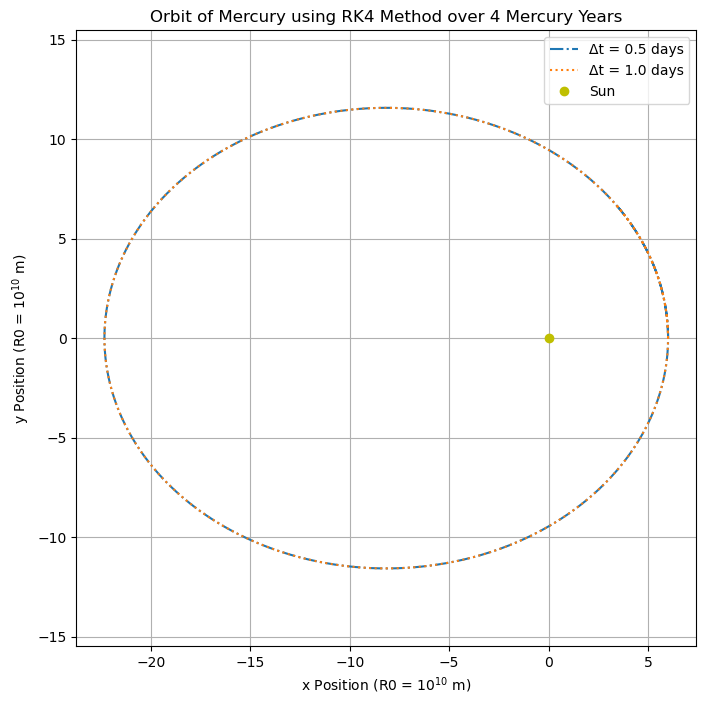

In [8]:
# ----------------------------
# 5. Plotting the Orbits in Separate Graphs
# ----------------------------

# Create a figure for each numerical method
for method_name in methods.keys():
    plt.figure(figsize=(8, 8))
    plt.xlabel("x Position (R0 = $10^{10}$ m)")
    plt.ylabel("y Position (R0 = $10^{10}$ m)")
    plt.title(f"Orbit of Mercury using {method_name} Method over 4 Mercury Years")
    plt.grid(True)
    plt.axis('equal')  # Ensure equal scaling on both axes
    
    # Define linestyle mappings based on delta_t
    linestyle_map = {
        5e-4: '--',
        5e-1: '-.',
        1.0: ':'
    }
    
    # Iterate through simulation_results and plot matching method
    for res in simulation_results:
        if res['method'] == method_name:
            delta_t = res['delta_t_days']
            x_plot = res['x'] / R0      # Scale positions to R0 for plotting
            y_plot = res['y'] / R0
            label = f"Δt = {delta_t} days"
            
            # Choose linestyle based on delta_t
            linestyle = linestyle_map.get(delta_t, '-')
            
            plt.plot(x_plot, y_plot, label=label, linestyle=linestyle)
    
    # Plot the Sun at the origin
    plt.plot(0, 0, 'yo', label='Sun')
    
    # Add legend
    plt.legend()
    plt.show()


Swept Areas Analysis (RK4 Method):
Mean Swept Area per Time Step: 7.650e+19 m²
Standard Deviation of Swept Areas: 3.854e+15 m²
Relative Variation: 0.01%



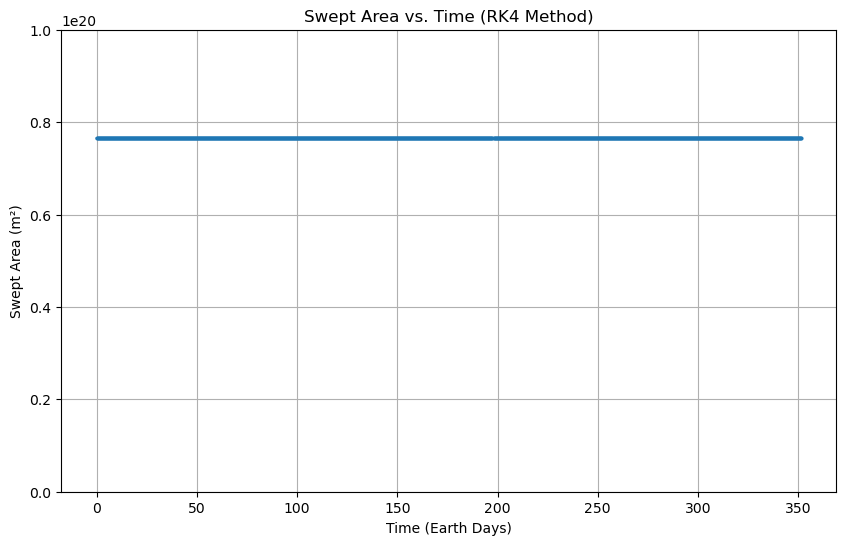

In [9]:
# ----------------------------------------------------------------
# part 3
# ----------------------------------------------------------------

def calculate_swept_areas(x, y):

    # Using the shoelace formula for consecutive points (Gauss's area formula)
    # since one of the points is always at the origin (0, 0), we need to only consider the other two points

    # Origin (0,0)
#    |
#    |\
#    | \
#    |  \
#    |   \
#    |    \
#    |     \  P2 (x1, y1)
#    |
#    P1 (x0, y0)

    areas = 0.5 * np.abs(x[:-1] * y[1:] - x[1:] * y[:-1])
    return areas

def analyze_swept_areas(areas):

    mean_area = np.mean(areas)
    std_dev_area = np.std(areas)
    relative_variation = (std_dev_area / mean_area) * 100  # Percentage
    
    return mean_area, std_dev_area, relative_variation

def plot_swept_areas_over_time(t, areas):

    plt.figure(figsize=(10, 6))
    time_days = t[:-1] / T0  # Convert time to Earth days
    plt.plot(time_days, areas, marker='o', linestyle='-', markersize=2)
    plt.title("Swept Area vs. Time (RK4 Method)")
    plt.ylim(0, 10 * 1e19)
    plt.xlabel("Time (Earth Days)")
    plt.ylabel("Swept Area (m²)")
    plt.grid(True)
    plt.show()

    # Extract RK4 Simulation Results
rk4_results = [res for res in simulation_results if res['method'] == 'RK4']

# Assuming you've run only one RK4 simulation; adjust if multiple
if len(rk4_results) == 0:
    print("No RK4 simulation results found.")
else:
    # For demonstration, take the first RK4 result
    rk4 = rk4_results[0]
    t_rk4 = rk4['t']        # Time array (seconds)
    x_rk4 = rk4['x']        # x-position array (meters)
    y_rk4 = rk4['y']        # y-position array (meters)
    
    # Calculate Swept Areas
    swept_areas = calculate_swept_areas(x_rk4, y_rk4)

    # Perform Statistical Analysis
    mean_area, std_dev_area, relative_variation = analyze_swept_areas(swept_areas)
    print("Swept Areas Analysis (RK4 Method):")
    print(f"Mean Swept Area per Time Step: {mean_area:.3e} m²")
    print(f"Standard Deviation of Swept Areas: {std_dev_area:.3e} m²")
    print(f"Relative Variation: {relative_variation:.2f}%\n")

    plot_swept_areas_over_time(t_rk4, swept_areas)

# explanation
# I use the resukt in runge-jutta method to calculate the swept area of mercury over time for each time interveral. Since the kepler's second law 
# states that the area swept out by a planet in a given time interval is constant, the swept area of mercury over time should be constant. 
# from the result below,  we can see that the swept area is constant over time as relative variabltion is close to zero . This result is consistent with kepler's second law.


Running Leap-Frog-GR Method with Δt = 0.05 Earth days (4320.00 seconds)
Completed Leap-Frog-GR Method with Δt = 0.05 Earth days

Running RK4-GR Method with Δt = 0.05 Earth days (4320.00 seconds)
Completed RK4-GR Method with Δt = 0.05 Earth days



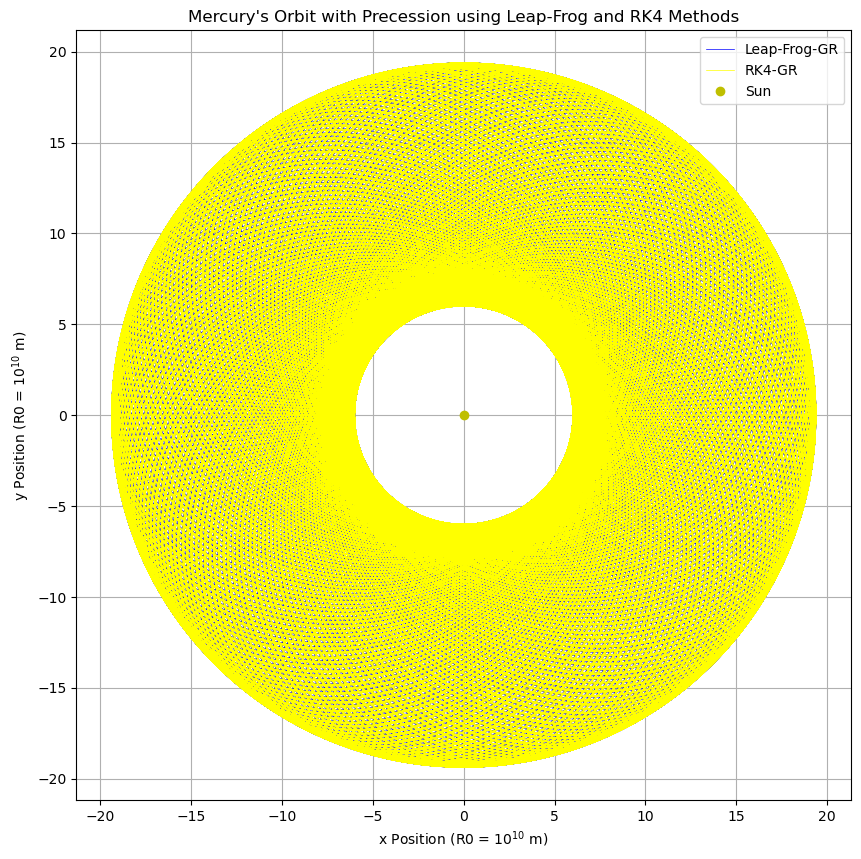

In [10]:
# rewrite some functions and add new constants and recalculate the Schwarzschild radius of the Sun
# Declaimer: since the there are many steps, it will take a while to run the code.
# The code are mostly the same as the previous one, the only difference is the new constants and slight admentment in the functions

r_l_sq = 8.19e-17
total_time_days = 200000
total_time = total_time_days * T0  

def compute_gravitational_acceleration_GR(x, y, c, r_s):
    r = np.sqrt(x**2 + y**2)
    
    if r == 0:
        raise ValueError("Mercury is at the origin (r = 0), which is undefined for acceleration.")
    
    factor = -(c**2 * r_s) / (2 * r**3) *(1 + 10**6*r_s/r + 10**6*(r_l_sq/r**2))
    a_x = factor * x
    a_y = factor * y
    
    return a_x, a_y

def leap_frog_method_GR(tau, total_time, x0, y0, v_x0, v_y0, r_s, c):

    steps = int(total_time / tau)
    # Initialize arrays
    t_array = np.zeros(steps+1)
    x_array = np.zeros(steps+1)
    y_array = np.zeros(steps+1)
    v_x_array = np.zeros(steps+1)
    v_y_array = np.zeros(steps+1)
    
    # Set initial conditions
    t_array[0] = 0.0
    x_array[0] = x0
    y_array[0] = y0
    v_x_array[0] = v_x0
    v_y_array[0] = v_y0
    
    # Compute initial acceleration
    try:
        a_x_initial, a_y_initial = compute_gravitational_acceleration_GR(x0, y0, c, r_s)
    except ValueError as e:
        print(f"Leap-Frog Method: {e} at initial step")
        return t_array, x_array, y_array, v_x_array, v_y_array
    
    # Half-step velocity update
    v_x_half = v_x0 + 0.5 * a_x_initial * tau
    v_y_half = v_y0 + 0.5 * a_y_initial * tau
    
    for i in range(steps):
        # Update positions using half-step velocities
        x_array[i+1] = x_array[i] + v_x_half * tau
        y_array[i+1] = y_array[i] + v_y_half * tau
        
        # Update time
        t_array[i+1] = t_array[i] + tau
        
        # Compute acceleration at new position
     
        a_x_new, a_y_new = compute_gravitational_acceleration_GR(x_array[i+1], y_array[i+1], c, r_s)

        # Update half-step velocities
        v_x_half += a_x_new * tau
        v_y_half += a_y_new * tau
        
        # Full-step velocity update
        v_x_array[i+1] = v_x_half - 0.5 * a_x_new * tau
        v_y_array[i+1] = v_y_half - 0.5 * a_y_new * tau
        
        # Termination condition: Mercury gets too close to the Sun
        r = np.sqrt(x_array[i+1]**2 + y_array[i+1]**2)
        if r < 0.47 * R0:
            print(f"Leap-Frog Method: Terminating simulation at step {i+1}, r = {r:.3e} m")
            # Truncate arrays up to current step +1
            t_array = t_array[:i+2]
            x_array = x_array[:i+2]
            y_array = y_array[:i+2]
            v_x_array = v_x_array[:i+2]
            v_y_array = v_y_array[:i+2]
            break
    
    return t_array, x_array, y_array, v_x_array, v_y_array

def rk4_method_GR(tau, total_time, x0, y0, v_x0, v_y0, r_s, c):

    steps = int(total_time / tau)
    # print("steps", steps)
    # Initialize arrays
    t_array = np.zeros(steps+1)
    x_array = np.zeros(steps+1)
    y_array = np.zeros(steps+1)
    v_x_array = np.zeros(steps+1)
    v_y_array = np.zeros(steps+1)
    
    # Set initial conditions
    t_array[0] = 0.0
    x_array[0] = x0
    y_array[0] = y0
    v_x_array[0] = v_x0
    v_y_array[0] = v_y0
    
    for i in range(steps):
        # Current state
        current_t = t_array[i]
        current_x = x_array[i]
        current_y = y_array[i]
        current_vx = v_x_array[i]
        current_vy = v_y_array[i]
        
        # Compute k1

        a_x1, a_y1 = compute_gravitational_acceleration_GR(current_x, current_y, c, r_s)

        k1_vx = a_x1
        k1_vy = a_y1
        k1_x = current_vx
        k1_y = current_vy
        
        # Compute k2
        mid_x = current_x + 0.5 * tau * k1_x
        mid_y = current_y + 0.5 * tau * k1_y
        
        a_x2, a_y2 = compute_gravitational_acceleration_GR(mid_x, mid_y, c, r_s)

        k2_vx = a_x2
        k2_vy = a_y2
        k2_x = current_vx + 0.5 * tau * k1_vx
        k2_y = current_vy + 0.5 * tau * k1_vy
        
        # Compute k3
        mid_x = current_x + 0.5 * tau * k2_x
        mid_y = current_y + 0.5 * tau * k2_y
     
        a_x3, a_y3 = compute_gravitational_acceleration_GR(mid_x, mid_y, c, r_s)

        k3_vx = a_x3
        k3_vy = a_y3
        k3_x = current_vx + 0.5 * tau * k2_vx
        k3_y = current_vy + 0.5 * tau * k2_vy
        
        # Compute k4
        end_x = current_x + tau * k3_x
        end_y = current_y + tau * k3_y
        
        a_x4, a_y4 = compute_gravitational_acceleration_GR(end_x, end_y, c, r_s)

        k4_vx = a_x4
        k4_vy = a_y4
        k4_x = current_vx + tau * k3_vx
        k4_y = current_vy + tau * k3_vy
        
        # Update positions
        x_array[i+1] = current_x + (tau / 6.0) * (k1_x + 2*k2_x + 2*k3_x + k4_x)
        y_array[i+1] = current_y + (tau / 6.0) * (k1_y + 2*k2_y + 2*k3_y + k4_y)
        
        # Update velocities
        v_x_array[i+1] = current_vx + (tau / 6.0) * (k1_vx + 2*k2_vx + 2*k3_vx + k4_vx)
        v_y_array[i+1] = current_vy + (tau / 6.0) * (k1_vy + 2*k2_vy + 2*k3_vy + k4_vy)
        
        # Update time
        t_array[i+1] = t_array[i] + tau
        
        # Termination condition: Mercury gets too close to the Sun
        r = np.sqrt(x_array[i+1]**2 + y_array[i+1]**2)
        if r < 0.47 * R0:
            print(f"RK4 Method: Terminating simulation at step {i+1}, r = {r:.3e} meters")
            # Truncate arrays up to current step +1
            t_array = t_array[:i+2]
            x_array = x_array[:i+2]
            y_array = y_array[:i+2]
            v_x_array = v_x_array[:i+2]
            v_y_array = v_y_array[:i+2]
            break
    
    return t_array, x_array, y_array, v_x_array, v_y_array

# Iterate over each method and its time steps

# Define simulation methods and their respective delta t's
methods2 = {
    'Leap-Frog-GR': delta_ts_leapfrog_GR,  # Only using Δt = 0.05 Earth days as per question
    'RK4-GR': delta_ts_rk4_GR        # Only using Δt = 0.05 Earth days as per question
}

# Initialize storage again for simulation results
simulation_results = []

# Iterate over each method and its time steps
for method_name, delta_ts in methods2.items():
    for tau_days in delta_ts:
        tau_seconds = tau_days * T0    # Convert Earth days to seconds
        print(f"Running {method_name} Method with Δt = {tau_days} Earth days ({tau_seconds:.2f} seconds)")
        
        # Perform simulation based on the method
        if method_name == 'Leap-Frog-GR':
            t, x, y, v_x, v_y = leap_frog_method_GR(tau_seconds, total_time, x0, y0, v_x0, v_y0, r_s, c)
        elif method_name == 'RK4-GR':
            t, x, y, v_x, v_y = rk4_method_GR(tau_seconds, total_time, x0, y0, v_x0, v_y0, r_s, c)
        else:
            print(f"Unknown method: {method_name}. Skipping...")
            continue
        
        # Store the results
        simulation_results.append({
            'method': method_name,
            'delta_t_days': tau_days,
            't': t,
            'x': x,
            'y': y,
            'v_x': v_x,
            'v_y': v_y
        })
        print(f"Completed {method_name} Method with Δt = {tau_days} Earth days\n")

# Colors and markers for distinction
colors = {
    'Leap-Frog-GR': 'blue',
    'RK4-GR': 'yellow'
} 

plt.figure(figsize=(10, 10))
plt.xlabel("x Position (R0 = $10^{10}$ m)")
plt.ylabel("y Position (R0 = $10^{10}$ m)")
plt.title("Mercury's Orbit with Precession using Leap-Frog and RK4 Methods")
plt.grid(True)
plt.axis('equal')  # Ensure equal scaling on both axes


# Plot each simulation
# print("lenge of simulation_results", len(simulation_results))
for res in simulation_results:
    method = res['method']
    x_plot = res['x'] / R0      # Scale positions to R0 for plotting
    y_plot = res['y'] / R0
    label = method
    plt.plot(x_plot, y_plot, color=colors.get(method, 'black'), label=label, linewidth=0.5)

# Plot the Sun at the origin
plt.plot(0, 0, 'yo', label='Sun')

# Add legend
plt.legend()
plt.show()